<a href="https://www.kaggle.com/code/emanafi/text-to-image-generation-with-birds-using-cgan?scriptVersionId=247839252" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **1. Dataset Setup:**

In [1]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from transformers import AutoTokenizer

In [2]:
# Define dataset paths
dataset_path = "/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/"
images_folder = os.path.join(dataset_path, "images")
classes_file = os.path.join(dataset_path, "classes.txt")
images_file = os.path.join(dataset_path, "images.txt")
split_file = os.path.join(dataset_path, "train_test_split.txt")

# Load and merge metadata
classes = pd.read_csv(classes_file, sep=" ", header=None, names=["class_id", "class_name"])
images = pd.read_csv(images_file, sep=" ", header=None, names=["image_id", "file_path"])
split = pd.read_csv(split_file, sep=" ", header=None, names=["image_id", "is_train"])

# Merge dataframes
images["class_name"] = images["file_path"].apply(lambda x: x.split("/")[0])
metadata = images.merge(split, on="image_id").merge(classes, on="class_name")
metadata["file_path"] = metadata["file_path"].apply(lambda x: os.path.join(images_folder, x))

# Display sample metadata
print("Sample Metadata:")
print(metadata.head())

Sample Metadata:
   image_id                                          file_path  \
0         1  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
1         2  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
2         3  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
3         4  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
4         5  /kaggle/input/assignment-3-cub200-2011/CUB_200...   

                   class_name  is_train  class_id  
0  001.Black_footed_Albatross         0         1  
1  001.Black_footed_Albatross         1         1  
2  001.Black_footed_Albatross         0         1  
3  001.Black_footed_Albatross         1         1  
4  001.Black_footed_Albatross         1         1  


# **2. Data Preprocessing:**

In [3]:
# Initialize BERT tokenizer with clean_up_tokenization_spaces set to False
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", clean_up_tokenization_spaces=False)

# Tokenize text
def preprocess_text(texts, max_length=128):
    tokens = tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return tokens["input_ids"]

# Preprocess images
def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])  # Ensure images are resized to 64x64
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Create dataset pipeline
def create_combined_dataset(metadata):
    file_paths = metadata["file_path"].values
    text_input_ids = preprocess_text(metadata["class_name"])
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, text_input_ids))
    dataset = dataset.map(
        lambda path, text: (preprocess_image(path), text),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(16).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create the dataset
combined_dataset = create_combined_dataset(metadata)

# Display a batch for debugging
for image_batch, text_batch in combined_dataset.take(1):
    print("Image Batch Shape:", image_batch.shape)  # Expected: (16, 64, 64, 3)
    print("Text Batch Shape:", text_batch.shape)    # Expected: (16, 128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Image Batch Shape: (16, 64, 64, 3)
Text Batch Shape: (16, 128)


# **3. GAN Implementation:**

In [4]:
# Define model parameters
noise_dim = 100
embedding_dim = 128  # Dimension of the final text embedding vector
max_length = 128     # Max length of tokenized text (must match tokenizer)

# NEW: Build a Text Encoder to create meaningful embeddings
def build_text_encoder(vocab_size, embedding_dim, max_length):
    """Takes token IDs and outputs a dense embedding vector."""
    input_layer = layers.Input(shape=(max_length,), name="text_input_ids")
    # Embedding layer maps each token ID to a vector
    embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=256)(input_layer)
    # Pooling reduces the sequence of vectors to a single vector
    pooling_layer = layers.GlobalAveragePooling1D()(embedding_layer)
    # A dense layer to get the final desired embedding dimension
    output_layer = layers.Dense(embedding_dim, activation="relu")(pooling_layer)
    
    encoder = Model(input_layer, output_layer, name="TextEncoder")
    return encoder

# UPDATED: Generator now takes noise and a pre-computed text embedding
def build_generator(noise_dim, embedding_dim):
    noise_input = layers.Input(shape=(noise_dim,), name="noise_input")
    # This input is now the output of the TextEncoder
    text_embedding_input = layers.Input(shape=(embedding_dim,), name="text_embedding_input")

    combined_input = layers.Concatenate()([noise_input, text_embedding_input])

    x = layers.Dense(8 * 8 * 256, use_bias=False)(combined_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    # This layer upsamples to the final 64x64 resolution
    x = layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final layer to produce the 3-channel image
    output = layers.Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)

    generator = Model([noise_input, text_embedding_input], output, name="Generator")
    return generator

# Discriminator now takes an image and a pre-computed text embedding
def build_discriminator(image_shape, embedding_dim):
    image_input = layers.Input(shape=image_shape, name="image_input")
    # This input is now the output of the TextEncoder
    text_embedding_input = layers.Input(shape=(embedding_dim,), name="text_embedding_input")

    # Project and reshape the text embedding to match the image's spatial dimensions
    # This helps the discriminator check if the image matches the text at a feature level
    text_spatial = layers.Dense(4 * 4 * 64, activation='relu')(text_embedding_input)
    text_spatial = layers.Reshape((4, 4, 64))(text_spatial)

    # Downsample image
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(image_input) # 64x64 -> 32x32
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x) # 32x32 -> 16x16
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, kernel_size=5, strides=2, padding='same')(x) # 16x16 -> 8x8
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, kernel_size=5, strides=2, padding='same')(x) # 8x8 -> 4x4
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Concatenate the downsampled image features with the reshaped text features
    combined_features = layers.Concatenate()([x, text_spatial])

    # Final convolutional layer before making a decision
    x = layers.Conv2D(512, kernel_size=1, padding='same')(combined_features)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x) # Use from_logits=True in loss for stability

    discriminator = Model([image_input, text_embedding_input], output, name="Discriminator")
    return discriminator


# Build all models
text_encoder = build_text_encoder(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=embedding_dim,
    max_length=max_length
)
generator = build_generator(noise_dim=noise_dim, embedding_dim=embedding_dim)
discriminator = build_discriminator(image_shape=(64, 64, 3), embedding_dim=embedding_dim)

# Print summaries to verify
print("--- Text Encoder Summary ---")
text_encoder.summary()
print("\n--- Generator Summary ---")
generator.summary()
print("\n--- Discriminator Summary ---")
discriminator.summary()

--- Text Encoder Summary ---


Model: "TextEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input_ids (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 256)       │     7,813,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,846,528 (29.93 MB)

 Trainable params: 7,846,528 (29.93 MB)

 Non-trainable params: 0 (0.00 B)


--- Generator Summary ---


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding_inp… │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 228)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ text_embedding_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16384)     │  3,735,552 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16384)     │     65,536 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16384)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 256) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    819,200 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    204,800 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │     51,200 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64, 3) │      2,403 │ leaky_re_lu_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,879,587 (18.61 MB)

 Trainable params: 4,846,371 (18.49 MB)

 Non-trainable params: 33,216 (129.75 KB)


--- Discriminator Summary ---


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,864 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    204,928 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    819,456 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  3,277,312 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding_inp… │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │    132,096 │ text_embedding_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 4, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4, 576) │          0 │ leaky_re_lu_7[0]… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 512) │    295,424 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,747,905 (18.11 MB)

 Trainable params: 4,745,089 (18.10 MB)

 Non-trainable params: 2,816 (11.00 KB)

# **4. Training the cGAN:**

--- Starting Training ---
Epoch 1/1000 | Gen Loss: 3.8825 | Disc Loss: 0.5031 | Time: 56.90s
Epoch 2/1000 | Gen Loss: 2.5921 | Disc Loss: 0.6802 | Time: 38.63s
Epoch 3/1000 | Gen Loss: 3.1617 | Disc Loss: 0.4962 | Time: 40.34s
Epoch 4/1000 | Gen Loss: 3.6916 | Disc Loss: 0.3946 | Time: 41.32s
Epoch 5/1000 | Gen Loss: 3.8213 | Disc Loss: 0.3828 | Time: 40.94s
Epoch 6/1000 | Gen Loss: 3.6427 | Disc Loss: 0.4232 | Time: 41.05s
Epoch 7/1000 | Gen Loss: 3.6862 | Disc Loss: 0.4100 | Time: 41.04s
Epoch 8/1000 | Gen Loss: 3.6963 | Disc Loss: 0.3939 | Time: 40.97s
Epoch 9/1000 | Gen Loss: 3.6322 | Disc Loss: 0.3799 | Time: 41.05s
Epoch 10/1000 | Gen Loss: 3.8402 | Disc Loss: 0.3899 | Time: 41.09s
Epoch 11/1000 | Gen Loss: 3.7515 | Disc Loss: 0.3814 | Time: 41.13s
Epoch 12/1000 | Gen Loss: 3.7492 | Disc Loss: 0.3815 | Time: 41.09s
Epoch 13/1000 | Gen Loss: 3.9708 | Disc Loss: 0.3381 | Time: 41.02s
Epoch 14/1000 | Gen Loss: 3.9972 | Disc Loss: 0.3297 | Time: 40.99s
Epoch 15/1000 | Gen Loss: 3.993

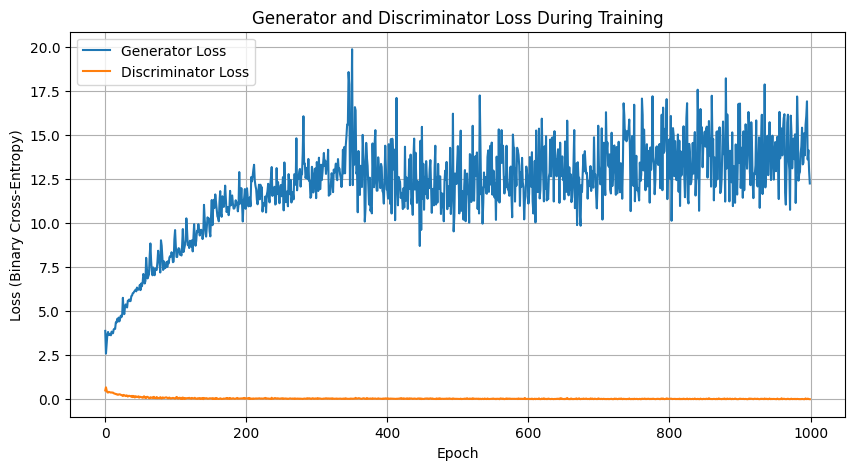

In [5]:
# --- 1. Setup Loss Functions and Optimizers ---

# Use from_logits=True for better numerical stability.
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Calculates how well the generator was able to fool the discriminator."""
    return bce_loss(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    """Calculates the discriminator's ability to distinguish real from fake."""
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# --- 2. Define the Core Training Step ---

@tf.function
def train_step(real_images, text_input_ids):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        text_embeddings = text_encoder(text_input_ids, training=True)
        fake_images = generator([noise, text_embeddings], training=True)
        real_output = discriminator([real_images, text_embeddings], training=True)
        fake_output = discriminator([fake_images, text_embeddings], training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_trainable_vars = discriminator.trainable_variables + text_encoder.trainable_variables
    disc_gradients = disc_tape.gradient(disc_loss, disc_trainable_vars)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, disc_trainable_vars))

    return gen_loss, disc_loss

# --- 3. The Main Training Loop ---

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    save_dir = "./training_output"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("--- Starting Training ---")
    for epoch in range(epochs):
        start_time = time.time()
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0

        for image_batch, text_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, text_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1
        
        avg_gen_loss = epoch_gen_loss / num_batches
        avg_disc_loss = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{epochs} | Gen Loss: {avg_gen_loss:.4f} | Disc Loss: {avg_disc_loss:.4f} | Time: {epoch_time:.2f}s")

        # Periodically save the models
        if (epoch + 1) % 50 == 0 or epoch == epochs - 1:
            print(f"--- Saving models for epoch {epoch + 1} ---")
            
            # FIX: The filename must end in `.weights.h5`
            generator.save_weights(os.path.join(save_dir, f"generator_epoch_{epoch+1}.weights.h5"))
            discriminator.save_weights(os.path.join(save_dir, f"discriminator_epoch_{epoch+1}.weights.h5"))
            text_encoder.save_weights(os.path.join(save_dir, f"text_encoder_epoch_{epoch+1}.weights.h5"))
            
    print("--- Training Finished ---")
    
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Generator and Discriminator Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Binary Cross-Entropy)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- START THE TRAINING PROCESS ---
num_epochs = 1000
train(combined_dataset, num_epochs)

# **5. Evaluation and Reflection:**

Successfully loaded weights from epoch 1000.

Generating images for the following classes: ['137.Cliff_Swallow', '184.Louisiana_Waterthrush', '048.European_Goldfinch', '035.Purple_Finch', '192.Downy_Woodpecker']


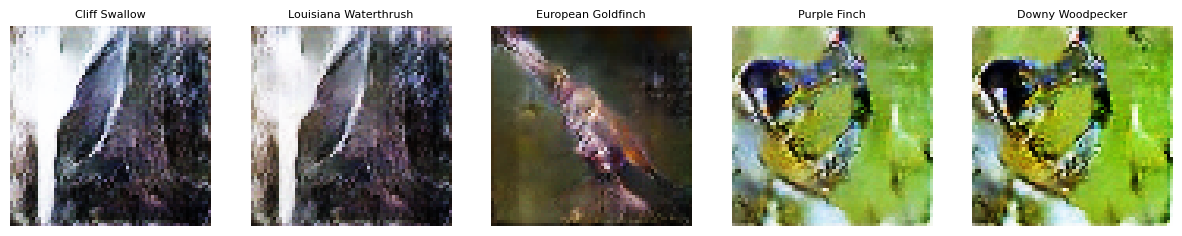

In [6]:
# --- 1. Load the Trained Model Weights ---
# The model architectures (generator, text_encoder) are still in memory from when you ran Cell 3.
# We just need to load the learned weights into them.

# IMPORTANT: Make sure the epoch number matches the weights you want to use.
# We will load the final weights saved at the end of the training run.
final_epoch = 1000  # This must match the `num_epochs` you trained for.
save_dir = "./training_output"
weights_file_gen = os.path.join(save_dir, f"generator_epoch_{final_epoch}.weights.h5")
weights_file_enc = os.path.join(save_dir, f"text_encoder_epoch_{final_epoch}.weights.h5")

try:
    generator.load_weights(weights_file_gen)
    text_encoder.load_weights(weights_file_enc)
    print(f"Successfully loaded weights from epoch {final_epoch}.")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Please ensure that training was completed and the weights files exist.")


# --- 2. Define and Call the Image Generation Function ---

def generate_images(generator, text_encoder, metadata, num_images=5):
    """Generates and displays synthetic images based on text prompts."""
    # Generate constant noise and text for consistent evaluation
    seed_noise = tf.random.normal([num_images, noise_dim])
    sample_metadata = metadata.sample(num_images, random_state=42) # Use a fixed random state for consistency
    sample_texts = sample_metadata["class_name"]
    print("\nGenerating images for the following classes:", sample_texts.tolist())

    # 1. Preprocess text to get token IDs
    text_input_ids = preprocess_text(sample_texts)
    
    # 2. Use the text_encoder to get embeddings
    text_embeddings = text_encoder(text_input_ids, training=False)
    
    # 3. Generate images from noise and text embeddings
    generated_images = generator([seed_noise, text_embeddings], training=False)

    plt.figure(figsize=(15, 5))
    for i, img in enumerate(generated_images):
        plt.subplot(1, num_images, i + 1)
        # Denormalize image from [-1, 1] to [0, 1] for display
        plt.imshow((img + 1) / 2.0)
        # Display a clean version of the class name as the title
        plt.title(sample_texts.iloc[i].split('.')[1].replace('_', ' '), fontsize=8)
        plt.axis("off")
    plt.show()

# Call the function to generate and visualize the images using the loaded models
generate_images(generator, text_encoder, metadata)

# **6. Knowledge Questions:**

**1.	GANs often face mode collapse, where the generator produces limited variations of data. What techniques can be introduced to mitigate mode collapse, and how would you evaluate their effectiveness in this assignment’s context?**

_Answer:_

Several strategies can be implemented to address mode collapse in GANs:
1.	Minibatch discrimination: This method enables the discriminator to simultaneously evaluate multiple samples within a batch, helping it identify when the generator creates similar outputs for different inputs.
2.	Feature matching: Rather than solely training the discriminator to differentiate between real and fake data, the generator is also trained to replicate the features of real data as identified by the discriminator.
3.	Unrolled GANs: This approach involves "unrolling" the discriminator's optimization by considering how future updates to the generator might affect its performance. This prevents the discriminator from becoming too dominant too quickly.
4.	Wasserstein GAN (WGAN): WGAN reduces mode collapse by using a loss function that provides smoother gradients, ensuring that the generator avoids getting stuck in a single mode.
In the context of cGANs for text-to-image generation, these methods can be assessed by analyzing the variety in the generated bird images. If the generator produces only a narrow range of bird species or similar images for different textual descriptions, incorporating techniques like minibatch discrimination or feature matching can help foster more diverse outputs.

**2.	Compare and contrast Wasserstein GANs (WGANs) with standard GANs in terms of training stability and convergence. Would WGAN principles be beneficial for the cGAN architecture used here? Why or why not?**

_Answer:_

For training stability and convergence:
- Standard GANs: A common challenge with standard GANs is instability during training. The adversarial loss can cause issues such as vanishing or exploding gradients, particularly when the discriminator becomes too powerful relative to the generator, which can stop the training process.
- WGANs: WGANs tackle these problems by introducing a loss function based on Wasserstein distance (or Earth Mover’s Distance). This results in smoother gradients and more consistent training. Additionally, WGANs replace the sigmoid activation with a linear one in the discriminator, making the loss function less sensitive to variations in the output range.
Regarding the applications of cGANs, incorporating WGAN principles could improve the training stability of the cGAN in this assignment. Since cGANs condition on BERT embeddings, which involve complex, high-dimensional data, the generator may encounter challenges in maintaining stability, especially when generating detailed images like birds. Applying the WGAN techniques could enhance the overall stability during training and reduce the risks of mode collapse or overfitting to specific elements of the textual descriptions.

**3.	How would you assess whether BERT embeddings capture enough semantic information relevant to the bird species in the dataset? Propose a method for evaluating their effectiveness.**

_Answer:_

To determine whether BERT embeddings effectively capture meaningful semantic information about bird species, several evaluation methods can be applied:
- Qualitative: Generate bird images based on textual descriptions and visually compare the results to see if the images accurately represent the described bird species, colors, and specific features such as beak shape or feather texture.
- Quantitative: Employ metrics like cosine similarity or other distance measures to compare the BERT embeddings of the textual descriptions with the features extracted from the generated images. If the feature vectors of the generated images are similar to those of real images, it suggests that the BERT embeddings are capturing the relevant semantic details.
- Doing user studies: Conduct a study where participants are asked to assess how closely the generated images match the textual descriptions. Strong correlations in the ratings would indicate that the BERT embeddings align well with the visual features of the generated images.

**4.	GAN training is inherently unstable due to the adversarial dynamics between the generator and discriminator. Propose a method to detect instability early in the training process and adjust hyperparameters dynamically to stabilize training.**

_Answer:_

The following strategies can be applied to detect instability in GANs early and adjust hyperparameters accordingly:

1.	Monitoring losses: Keeping track of both the generator's and discriminator's losses during training. Significant fluctuations, especially when the discriminator’s loss becomes much smaller than that of the generator, may signal instability.
2.	Gradient clipping: Applying gradient clipping when the magnitude of gradients exceeds a certain threshold, helping to prevent issues like exploding gradients.
3.	Dynamic learning rate adjustment: Using an adaptive learning rate optimizer along with a dynamic learning rate schedule. If instability is observed, lower the learning rate or apply decay to the learning rates of the generator or discriminator to avoid overfitting.
4.	Early stopping: Set up early stopping criteria based on the loss trends or performance on validation data to avoid continuing training when instability is apparent, saving computational resources.

**5.	Discuss the ethical implications of using cGANs in sensitive applications such as healthcare or media generation. What guidelines would you propose for responsible use?**

_Answer:_

The use of cGANs in sensitive fields like healthcare and media generation raises several ethical concerns, such as:
1.	Misinformation and deception: cGANs have the potential to create highly realistic images, which could be used to mislead or deceive people, particularly in media, where deepfakes might be exploited maliciously.
2.	Training data bias: If cGANs are trained on biased or incomplete datasets, they could generate outputs that reinforce these biases, which could be harmful in applications like healthcare, where fairness and representation are crucial.
3.	Privacy issues: In healthcare, GANs could be used to create synthetic medical images, leading to privacy concerns, particularly if such images are used without proper consent.
The guidelines for responsible use that would be proposed are:
- Maintain transparency and accountability regarding the training data and generation processes, especially in sensitive areas.
- Implement ethical guidelines and review systems to ensure fairness, safety, and adherence to legal standards when using GANs.
- Develop methods to detect and prevent harmful or misleading content created by GANs, especially in media and advertising.
- In healthcare, prioritize obtaining patient consent and ensure that synthetic data complies with ethical standards in medical research.

**6.	Text-to-image generation tasks raise concerns about intellectual property rights, especially when trained on publicly available datasets. Analyze how such concerns apply to this assignment and suggest ways to mitigate potential legal risks.**

_Answer:_

Using publicly available datasets for text-to-image generation can raise intellectual property issues in the following situations:
1.	If the generated images closely resemble copyrighted material or if the training data includes copyrighted content.
2.	If the text descriptions include copyrighted elements, such as excerpts from literary works or trademarked content.
Ways to mitigate potential legal risks are:
- Use open datasets: Choose datasets that are explicitly available for commercial and academic purposes, ensuring they come with proper licensing (e.g., CUB-200-2011).
- Data anonymization: Avoid using potentially sensitive or copyrighted text in datasets, ensuring that the textual descriptions do not violate copyright laws.
- Creative commons licensing: Apply the correct Creative Commons or other licenses when using generated images to clarify the usage rights.
- Generate fair use content: Design models to produce content that is original or transformative enough to avoid directly copying copyrighted works.